In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        # Энкодер: преобразует вход в скрытое представление
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Выход энкодера – параметры гауссовского распределения (среднее и логарифм дисперсии)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # μ (среднее)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # log(σ²)

        # Декодер: восстанавливает изображение из латентного вектора z
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        # Ре-параметризация: z = μ + ε * σ, где ε ~ N(0, I)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        # Используем сигмоиду, чтобы получить значения в диапазоне [0, 1]
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # x имеет размерность (batch, 1, 28, 28) — приводим к вектору
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    # Реконструктивный лосс: бинарная кросс-энтропия
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL-дивергенция между q(z|x) и p(z)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [ ]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_bce += BCE.item()
        total_kld += KLD.item()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} Batch {batch_idx}/{len(train_loader)}: "
                  f"Loss per sample: {loss.item()/len(data):.4f}")
    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")
    return avg_bce, avg_kld

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

Используем устройство: cuda


In [ ]:
batch_size = 128
epochs = 20

In [ ]:
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False
)

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
bce_losses = []
kld_losses = []

for epoch in range(1, epochs + 1):
    avg_bce, avg_kld = train(model, train_loader, optimizer, epoch, device)
    bce_losses.append(avg_bce)
    kld_losses.append(avg_kld)

Epoch 1 Batch 0/469: Loss per sample: 549.8085
Epoch 1 Batch 100/469: Loss per sample: 184.6103
Epoch 1 Batch 200/469: Loss per sample: 160.0684
Epoch 1 Batch 300/469: Loss per sample: 137.8454
Epoch 1 Batch 400/469: Loss per sample: 130.2252
====> Epoch: 1 Average loss: 163.8321, BCE: 148.0573, KLD: 15.7748
Epoch 2 Batch 0/469: Loss per sample: 132.1867
Epoch 2 Batch 100/469: Loss per sample: 129.3026
Epoch 2 Batch 200/469: Loss per sample: 122.0662
Epoch 2 Batch 300/469: Loss per sample: 118.2501
Epoch 2 Batch 400/469: Loss per sample: 123.5315
====> Epoch: 2 Average loss: 121.3660, BCE: 98.9721, KLD: 22.3939
Epoch 3 Batch 0/469: Loss per sample: 116.9502
Epoch 3 Batch 100/469: Loss per sample: 113.3915
Epoch 3 Batch 200/469: Loss per sample: 117.4108
Epoch 3 Batch 300/469: Loss per sample: 110.4986
Epoch 3 Batch 400/469: Loss per sample: 111.1898
====> Epoch: 3 Average loss: 114.3845, BCE: 90.4022, KLD: 23.9823
Epoch 4 Batch 0/469: Loss per sample: 113.5447
Epoch 4 Batch 100/469: Lo

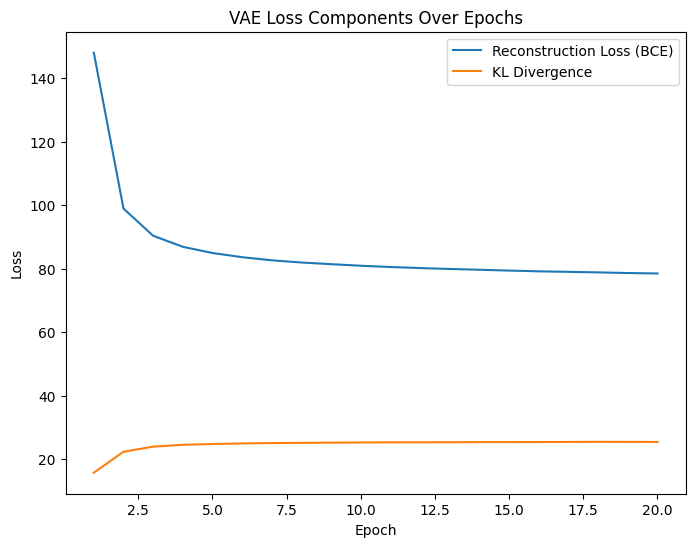

In [ ]:
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, bce_losses, label='Reconstruction Loss (BCE)')
plt.plot(epochs_range, kld_losses, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Loss Components Over Epochs")
plt.legend()
plt.show()

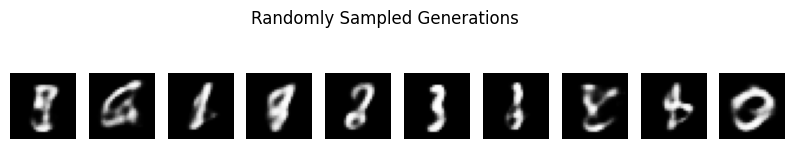

In [ ]:
with torch.no_grad():
    # Сэмплируем 10 случайных латентных векторов из N(0,I)
    sample = torch.randn(10, 20).to(device)
    sample = model.decode(sample).cpu()
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(sample[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Randomly Sampled Generations")
plt.show()

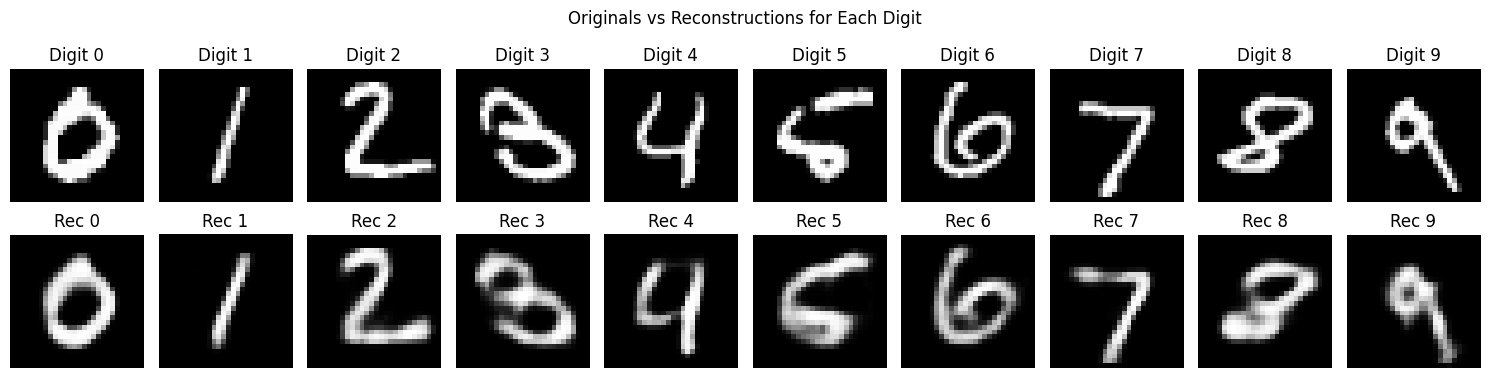

In [ ]:
model.eval()
digit_imgs = {}  # ключ: цифра, значение: изображение
with torch.no_grad():
    for data, targets in test_loader:
        for img, label in zip(data, targets):
            label = int(label.item())
            if label not in digit_imgs:
                digit_imgs[label] = img.unsqueeze(0)
            if len(digit_imgs) == 10:
                break
        if len(digit_imgs) == 10:
            break

originals = []
recons = []
for digit in range(10):
    img = digit_imgs[digit].to(device)
    recon, _, _ = model(img)
    originals.append(img.cpu())
    recons.append(recon.view(1, 1, 28, 28).detach().cpu())

# Построение графика: верхняя строка - оригиналы, нижняя строка - реконструкции
fig, axs = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axs[0, i].imshow(originals[i].squeeze(), cmap='gray')
    axs[0, i].set_title(f"Digit {i}")
    axs[0, i].axis('off')
    axs[1, i].imshow(recons[i].squeeze(), cmap='gray')
    axs[1, i].set_title(f"Rec {i}")
    axs[1, i].axis('off')
plt.suptitle("Originals vs Reconstructions for Each Digit")
plt.tight_layout()
plt.show()